In [1]:
# IMPORTO LIBRERIE

import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from Libreria_tesi import *

Definizioni delle condizioni sperimentali che si vuole riprodurre in accordo a paper "Projective measurements can probe nonclassical
work extraction and time correlations"

In [ ]:
# ————————————————————————————————
# 1) Definizioni di base secondo Eq. (16)
# ————————————————————————————————
hbar = 1.0
D       = 2.87      # zero‐field splitting [GHz]
gamma_e = 28.0      # gyromagnetic ratio [GHz/T]
B       = 0.01      # campo esterno [T]

# Base del qutrit |+1>, |0>, |-1>
e_plus  = basis(3, 0)
e_zero  = basis(3, 1)
e_minus = basis(3, 2)

# Hamiltoniana NV
Sz = Qobj(np.diag([+1, 0, -1]))
H_NV = D * Sz**2 + gamma_e * B * Sz

# ————————————————————————————————
# 2) Hamiltoniana nel S.d.R del laboratorio, Eq. (17)
# ——————————————————————————————————————————————————————————
# frequenze di Bohr
omega_p = D + gamma_e * B    # |0> <--> |+1>
omega_m = D - gamma_e * B    # |0> <--> |-1>

# operatori di transizione
P_p0 = e_plus  * e_zero.dag()  + e_zero * e_plus.dag()  # |+1> <--> |0>
P_m0 = e_minus * e_zero.dag()  + e_zero * e_minus.dag() # |-1> <--> |0>

# Rabi frequencies
Omega1 = 2.219 * 2*np.pi  * 10**(-3)         # MHz 
Omega2 = Omega1                               

def H_drive_lab(t, args):
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)  # da dizionario le fasi oppure setto a zero
    H1 = Omega1 * np.cos(omega_p * t + phi1) * P_p0
    H2 = Omega2 * np.cos(omega_m * t + phi2) * P_m0
    return H1 + H2

# lista per qutip
H_lab = [
    H_NV,   # parte stazionaria
    [P_p0, lambda t, args: hbar*Omega1 * np.cos(omega_p * t + args.get('phi1',0)*t)],
    [P_m0, lambda t, args: hbar*Omega2 * np.cos(omega_m * t + args.get('phi2',0)*t)]
]

# ————————————————————————————————
# 3) Hamiltoniana nel rotating frame, Eq. (18)
# ——————————————————————————————————————————————
# Matrici di Gell-Mann
lambda1 = Qobj([[0,1,0],[1,0,0],[0,0,0]])
lambda2 = Qobj([[0,-1j,0],[1j,0,0],[0,0,0]])
lambda6 = Qobj([[0,0,0],[0,0,1],[0,1,0]])
lambda7 = Qobj([[0,0,0],[0,0,-1j],[0,1j,0]])

Sx1 = lambda1/np.sqrt(2)
Sy1 = lambda2/np.sqrt(2)
Sx2 = lambda6/np.sqrt(2)
Sy2 = lambda7/np.sqrt(2)

def H_rot(t, args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}):
    # fasi lineari
    phi1, phi2 = args.get('phi1',0), args.get('phi2',0)
    return ( Omega1*(Sx1 * np.cos(phi1*t) + Sy1 * np.sin(phi1*t))
           + Omega2*(Sx2 * np.cos(phi2*t) - Sy2 * np.sin(phi2*t)) )

H_mw_rot = [
    [Sx1, lambda t,args:  Omega1 * np.cos(args.get('phi1',0)*t)],
    [Sy1, lambda t,args:  Omega1 * np.sin(args.get('phi1',0)*t)],
    [Sx2, lambda t,args:  Omega2 * np.cos(args.get('phi2',0)*t)],
    [Sy2, lambda t,args: -Omega2 * np.sin(args.get('phi2',0)*t)],
]

# ———————————————————
# 4) Stato iniziale 
# ———————————————————
p_plus, p_zero, p_minus = 0.7654, 0.0009, 0.2338
a_plus, a_zero, a_minus = 0.0073, 0.2787, 0.0002


H_val = H_rot(0, args = {}) # Hamiltoniana iniziale nel frame ruotato

en, aut = H_val.eigenstates()

vet_m, vet_0, vet_p = aut

xi = (
    np.sqrt(p_plus ) * np.exp(2j*np.pi*a_plus ) * vet_p  +
    np.sqrt(p_zero ) * np.exp(2j*np.pi*a_zero ) * vet_0  +
    np.sqrt(p_minus) * np.exp(2j*np.pi*a_minus) * vet_m
).unit()

# Stato iniziale (matrice densità)
rho_xi = xi * xi.dag()




Confronto ad un dato istante temporale fra le MHQ e le probabilità restituite dallo schema TPM

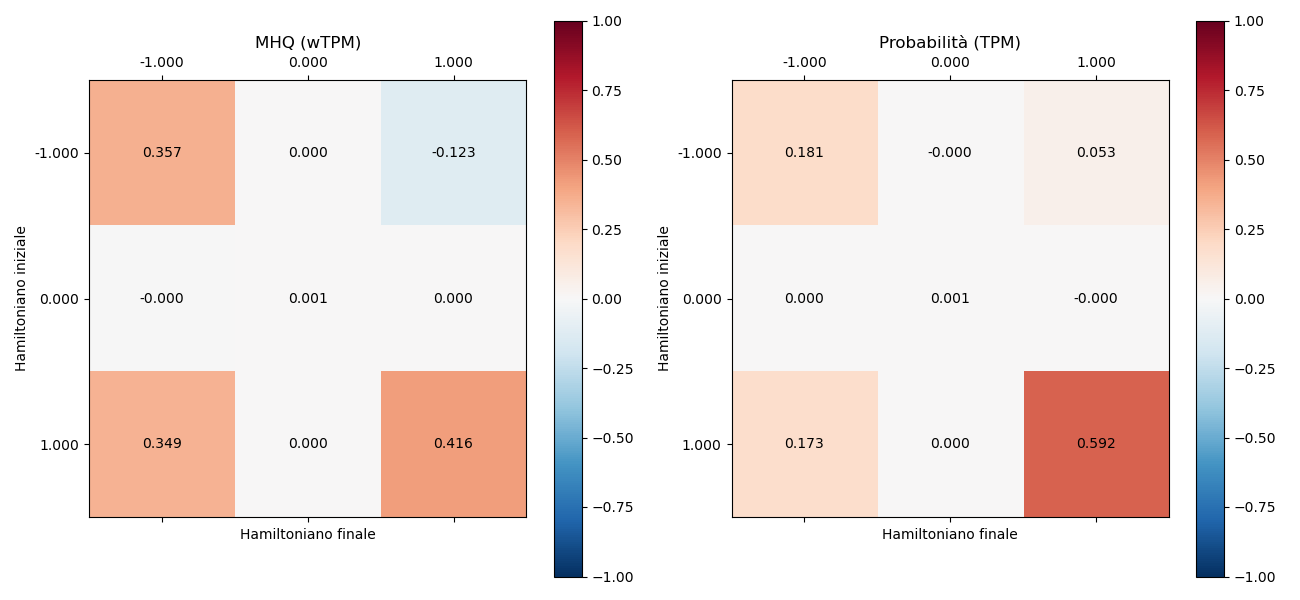

Verifica marginalizzazione:
p_TPM marginals = 0.3539, p_END[0] = 0.7062, Q[:,0] = 0.7062
p_TPM marginals = 0.0009, p_END[1] = 0.0009, Q[:,1] = 0.0009
p_TPM marginals = 0.6452, p_END[2] = 0.2929, Q[:,2] = 0.2929

Somma totale TPM: 1.0000
Somma totale MHQ: 1.0000


In [14]:
%matplotlib widget

# intervallo temporale
t_max = 700
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)



# Dephasing puro
L5 = e_zero * e_zero.dag() - e_minus * e_minus.dag()
L6 = e_plus * e_plus.dag() - e_zero * e_zero.dag()

gamma_phi_5 = 0.00001
gamma_phi_6 = 0.00001

c_ops = [
    np.sqrt(gamma_phi_5) * L5,
    np.sqrt(gamma_phi_6) * L6,
]

    
# Operatori iniziale e finale
H_iniziale = H_rot(0, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                        
H_finale = H_rot(t_list[-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})                  

# Calcolo MHQ
Q, TPM, probabilita_finali = MHQ_3level_vecchia(rho_xi, H_mw_rot, [], H_iniziale, H_finale, t_list[:-1], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
    
# Estrazione autovalori per i labels
autovalori_1, _ = H_iniziale.eigenstates()
autovalori_2, _ = H_finale.eigenstates()
    
autovalori_1 = [np.real(val)/Omega1 for val in autovalori_1]
autovalori_2 = [np.real(val)/Omega1 for val in autovalori_2]
    
# Visualizzazione
plot_MHQ_3level(Q, TPM, autovalori_1, autovalori_2)
    
# Verifica marginalizzazione
print("Verifica marginalizzazione:")
for j in range(3):
    print(f"p_TPM marginals = {TPM[:,j].sum():.4f}, p_END[{j}] = {probabilita_finali[j]:.4f}, Q[:,{j}] = {Q[:,j].sum():.4f}")
    
print(f"\nSomma totale TPM: {TPM.sum():.4f}")
print(f"Somma totale MHQ: {Q.sum():.4f}")

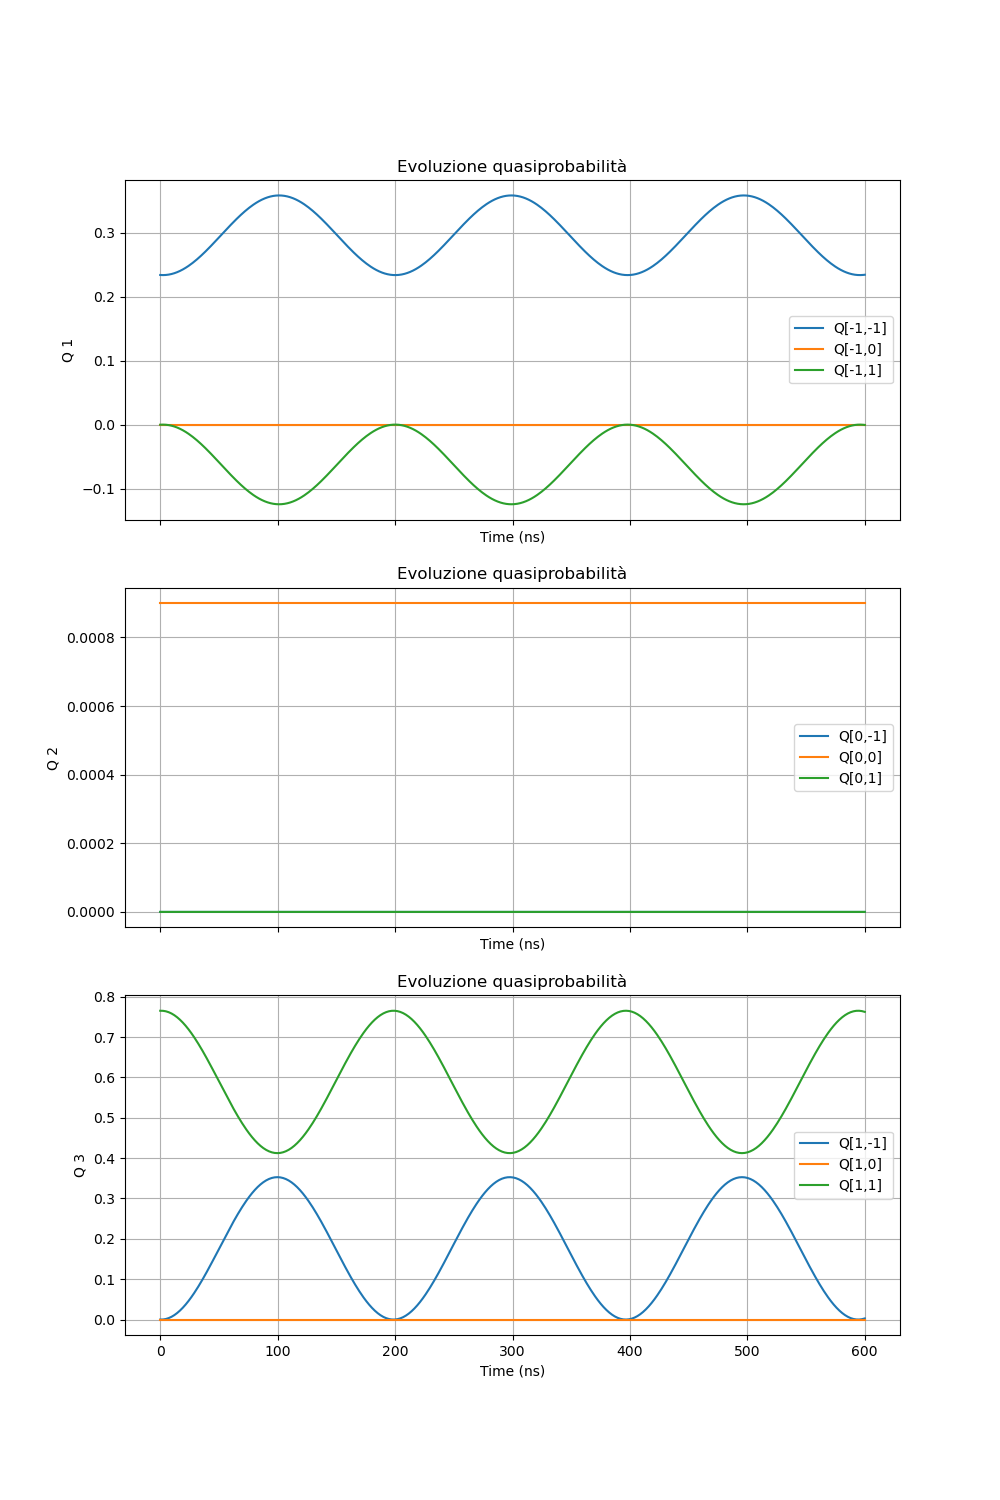

In [13]:
plt.close("all")



# intervallo temporale
t_max = 600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

# Inizializzo risultati
Q_evolution = np.zeros((n_steps, 3, 3)) # salvo le diverse matrici Q per ogni t
TPM_evolution = np.zeros((n_steps, 3, 3)) # salvo le TPM per ogni t
prob = np.zeros((n_steps, 3))

args = {'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2}

# Calcolo MHQ per ogni t_final
for idx, t_final in enumerate(t_list):
    t_sublist = t_list[:idx+1]  
    Q, TPM, iniziali = MHQ_3level(rho_xi, H_mw_rot, [], H_iniziale, H_rot(t_sublist[-1]), t_sublist, args = args, iniziali= False)  
    Q_evolution[idx] = Q
    TPM_evolution[idx] = TPM
    prob[idx] = iniziali



fig, ax = plt.subplots(3,1, figsize =(10, 15), sharex=True)
# Plot di Q[i,j](t)
for i in range(3):
    for j in range(3):
        ax[i].plot(t_list, Q_evolution[:, i, j], label=f'Q[{i-1},{j-1}]')
    ax[i].set_xlabel('Time (ns)')
    ax[i].set_ylabel(f'Q {i+1}')
    ax[i].set_title(f'Evoluzione quasiprobabilità')
    ax[i].grid()
    ax[i].legend()

plt.show()

Lavoro estraibile

In [5]:
lavoro = []
lavoro_TPM = [] 
temp = 0
H_iniziale = H_rot(0, args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
autovalori_1, _ = H_iniziale.eigenstates()
prova = []
prova_2 = []


for t in range(len(t_list)):
    temp = 0
    temp_TPM = 0
    for i in range(3):
        for j in range(3):
            h = H_rot(t_list[t], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
            energia, _ = h.eigenstates()
            temp += Q_evolution[t, i, j] * (autovalori_1[i] - energia[j])/ Omega1
            temp_TPM += TPM_evolution[t, i, j] * (autovalori_1[i] - energia[j]) / Omega1
    lavoro.append(temp)
    lavoro_TPM.append(temp_TPM)


def round_to_zero(x, threshold=1e-14):
    return 0 if abs(x) < threshold else x

for t in range(len(t_list)):
    temp = 0
    temp_2 = 0
    for i in range(3):
        for j in range(3):
            h = H_rot(t_list[t], args={'phi1': 1.09*Omega1, 'phi2': 1.09*Omega2})
            energia, _ = h.eigenstates()
            if (autovalori_1[i] - energia[j]) > 0:
                temp += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1
            else:
                temp_2 += np.sqrt(round_to_zero(TPM_evolution[t, i, j]*prob[t, j])) * (autovalori_1[i] - energia[j]) / Omega1
    prova.append(temp)
    prova_2.append(temp_2)
    


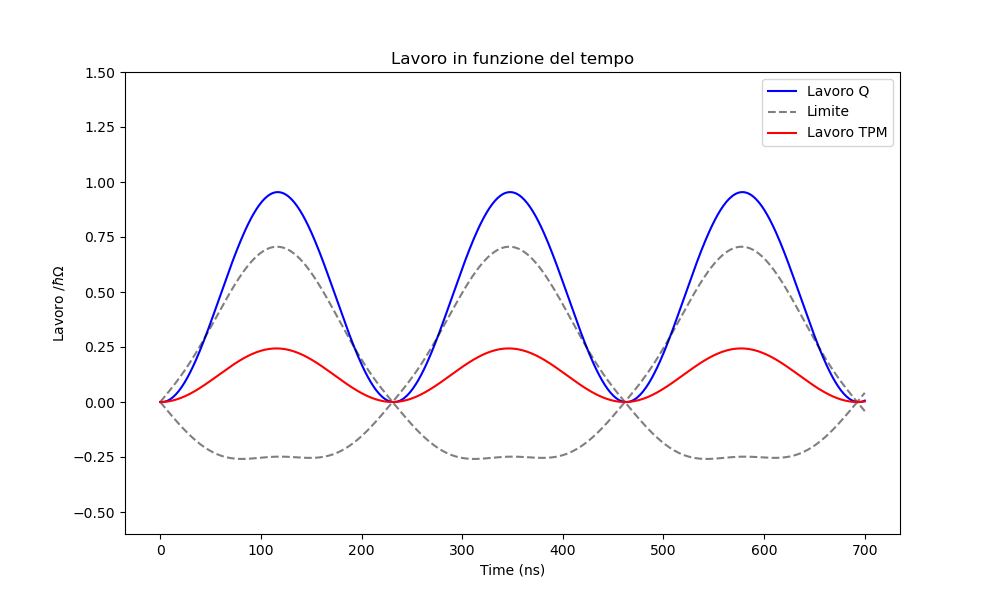

In [10]:
plt.close("all")
plt.figure(figsize=(10, 6))
plt.plot(t_list, lavoro, label='Lavoro Q', color = "b")
plt.plot(t_list, prova, label= "Limite", linestyle='--', color = "k", alpha=0.5)
plt.plot(t_list, prova_2, linestyle='--', color = "k", alpha=0.5)
plt.plot(t_list, lavoro_TPM, label='Lavoro TPM', color = "r")
plt.legend()
plt.ylim(-0.6, 1.5)
plt.xlabel('Time (ns)')
plt.ylabel(r'Lavoro /$\hbar\Omega$')
plt.title('Lavoro in funzione del tempo')
plt.show()
plt.grid()



In [43]:
print(prob[300])

[0.3744597  0.00089991 0.62464039]


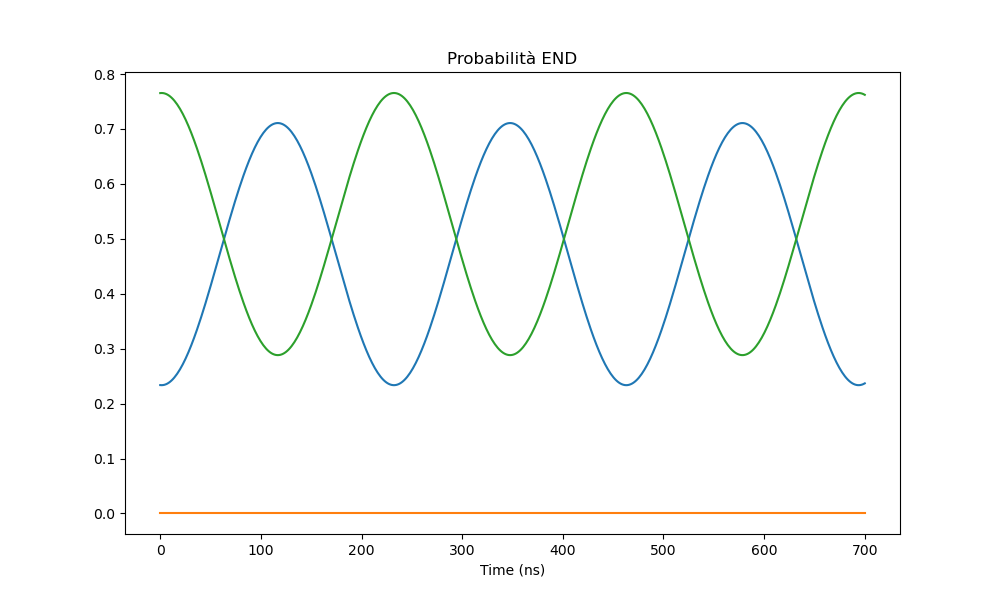

In [11]:
plt.close("all")
plt.figure(figsize=(10, 6))
plt.plot(t_list, prob[:])
plt.title('Probabilità END')
plt.xlabel('Time (ns)')
plt.show()
plt.grid()

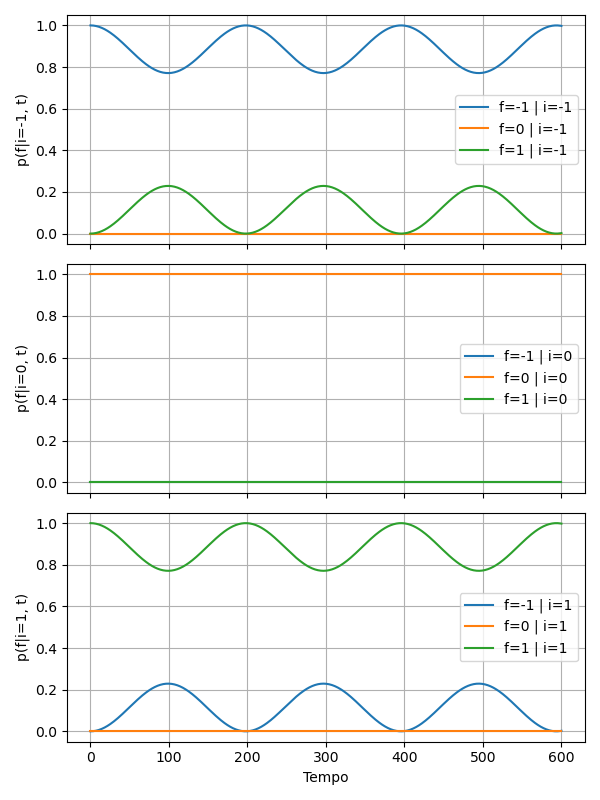

In [ ]:
plt.close("all")
# Calcolo
t_max = 600
n_steps = 500
t_list = np.linspace(0, t_max, n_steps)

TPM_time_inst = prob_condizionate( 
    rho_xi,
    H_mw_rot,
    c_ops=[],
    O1=H_iniziale,
    H_final_func=lambda t: H_rot(t),
    t_list=t_list,
    args={'phi1':1.09*Omega1, 'phi2':1.09*Omega2}
)


# Eseguire il plot
plot_prob_cond(TPM_time_inst, t_list)